In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu" 
    
device = "cpu"

In [3]:
torch.cuda.get_device_name(0)

C:\Users\P70074720\.conda\envs\pytorch36\lib\site-packages\torch\cuda\__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


'GeForce GTX 1080 Ti'

In [4]:
torch.cuda.current_device()

0

In [2]:
import torch
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [3]:
torch.cuda.set_device(0)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')


In [4]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

## Import data

In [5]:
traindatadir = '\\\\tsclient\\E\\Preprocessed\\TrainCalcClusterReal'
testdatadir = '\\\\tsclient\\E\\Preprocessed\\TestCalcClusterReal'
savedir = '\\\\tsclient\\E\\Models'

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, annotations_file, img_dir, mask_dir, transform=None, target_transform=None):
        # Read the .csv file with all the information
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        # Define the directories of the images and masks
        self.img_dir = os.path.join(root, img_dir)
        self.mask_dir = os.path.join(root, mask_dir)
        # Define whethet transformations are included
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Read the image and the mask for a case from the directories
        img_path = self.img_labels.iloc[idx, 0]
        mask_path = self.img_labels.iloc[idx,6]
        img_path = img_path.replace('E:', '\\\\tsclient\E')
        mask_path = mask_path.replace('E:', '\\\\tsclient\E')
        image = read_image(img_path).float()
        mask = read_image(mask_path)

        # Resize so all images and masks have the same size
#         image = T.Resize([800,800])(image)
#         mask = T.Resize([800,800])(mask)    
#         resize_scale_x = 800/image.size()[1]
#         resize_scale_y = 800/image.size()[2]


        # Resize if necessary
        # First the smallest dimension is reduced to 800 if it is larger
        # Then the largest dimension is reduced to 1300 if it is still larger
        resize_scale = 1.0
        min_size_idx = np.argmin([image.size()[1], image.size()[2]])
        
        if min_size_idx == 0 and image.size()[1] > 400 :
            resize_scale *= 400/image.size()[1]
            image = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(mask)
        if min_size_idx == 0 and image.size()[2] > 650 :
            resize_scale *= 650/image.size()[2]
            image = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(image)
            mask = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(mask)
        
        if min_size_idx == 1 and image.size()[2] > 400 :
            resize_scale *= 400/image.size()[2]
            image = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(image)
            mask = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(mask)
        if min_size_idx == 1 and image.size()[1] > 650 :
            resize_scale *= 650/image.size()[1]
            image = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(mask)
            
        # Normalize image with mean and standard deviation per channel
        mean = torch.mean(image, dim=(1,2))
        stdev = torch.std(image, dim=(1,2))
        image = T.Normalize(mean, stdev)(image)
        
        # Rescale to [0,1] range per channel
        for dim in range(3) :
            image[dim] -= torch.min(image[dim])
            image[dim] /= torch.max(image[dim])  
        
        # Create separate channel in mask for each lesion
        mask_out = np.zeros((torch.max(mask).item(), mask.shape[-2], mask.shape[-1]))
        for lesion_idx in range(torch.max(mask).item()) :
            mask_out[lesion_idx][mask[0]==lesion_idx+1] = 1      
        
        # Read the location of the lesion bounding box from the .csv file
        xmin = self.img_labels.iloc[idx, 1]
        xmax = self.img_labels.iloc[idx, 2]
        ymin = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
#         boxes = [[xmin*resize_scale, ymin*resize_scale, xmax*resize_scale, ymax*resize_scale]]
        boxes = [[ymin*resize_scale, xmin*resize_scale, ymax*resize_scale, xmax*resize_scale]]
#         boxes = [[xmin, ymin, xmax, ymax]]
        # Read the label of the lesion from the .csv file
        labels = self.img_labels.iloc[idx, 5]  
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        labels = torch.tensor([labels])
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        iscrowd = torch.zeros((2,), dtype=torch.int64)
        
        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)  
            
        target = {}
        target["image_id"] = image_id
        target["masks"] = mask_out
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["iscrowd"] = iscrowd
            
        return image, target


In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils

training_data = CustomImageDataset(traindatadir, 'annotations_train_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png')
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)

test_data = CustomImageDataset(testdatadir, 'annotations_test_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png')
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [8]:
# For Training

train_images, train_targets = next(iter(train_dataloader))
train_image_list = list(image for image in train_images)
train_target_list = [{k: v for k, v in t.items()} for t in train_targets]

# For Testing

test_images, test_targets = next(iter(test_dataloader))
test_image_list = list(image for image in test_images)
test_target_list = [{k: v for k, v in t.items()} for t in test_targets]

In [9]:
test_target_list

[{'image_id': tensor([25]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[408.0435, 119.3756, 419.9386, 134.0320]]),
  'area': tensor([174.3395]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([4]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[199.2280,  85.2044, 224.9146, 128.1199]]),
  'area': tensor([1102.3533]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([24]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],

tensor([83]) tensor([[365.8678, 246.6958, 381.6075, 265.9689]])
[315, 431, 196, 315]


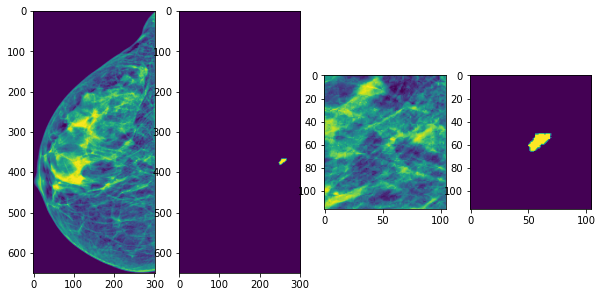

In [10]:
pat_idx = 3
print(train_targets[pat_idx]['image_id'], train_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(train_images[pat_idx][0])
ax[1].imshow(train_targets[pat_idx]['masks'][0])

enlarged_box = [int(train_targets[pat_idx]['boxes'][0][0])-50,
                int(train_targets[pat_idx]['boxes'][0][2])+50,
                int(train_targets[pat_idx]['boxes'][0][1])-50,                
                int(train_targets[pat_idx]['boxes'][0][3])+50]
print(enlarged_box)
ax[2].imshow(train_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(train_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

## Define model

In [11]:
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# backbone = torchvision.models.resnet101(pretrained=True, progress=True)
# backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=3,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler,
                 min_size=400,
                 max_size=650)

# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

In [12]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [46]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 2
# logs = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    sample next(iter(train_dataloader))
    
    epoch_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    logs.append(epoch_loss)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_dataloader, device=device)
    
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 'loss_classifier': loss_classifier,
#                 'loss_box_reg': loss_box_reg,
#                 'loss_mask': loss_mask,
#                 'loss_objectness': loss_objectness,
#                 'loss_rpn_box': loss_rpn_box
#                 }, savedir)
    
    if epoch % 5 == 0 :
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(savedir, 'model50_'+str(epoch)+'.pth'))

Epoch: [0]  [ 0/81]  eta: 0:09:13  lr: 0.000067  loss: 0.0388 (0.0388)  loss_classifier: 0.0013 (0.0013)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.0308 (0.0308)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 6.8374  data: 6.4312  max mem: 3970
Epoch: [0]  [10/81]  eta: 0:09:12  lr: 0.000692  loss: 0.0717 (0.0892)  loss_classifier: 0.0080 (0.0090)  loss_box_reg: 0.0000 (0.0006)  loss_mask: 0.0081 (0.0307)  loss_objectness: 0.0303 (0.0388)  loss_rpn_box_reg: 0.0067 (0.0101)  time: 7.7839  data: 7.3771  max mem: 3975
Epoch: [0]  [20/81]  eta: 0:08:06  lr: 0.001316  loss: 0.0727 (0.0930)  loss_classifier: 0.0080 (0.0087)  loss_box_reg: 0.0000 (0.0008)  loss_mask: 0.0081 (0.0329)  loss_objectness: 0.0298 (0.0404)  loss_rpn_box_reg: 0.0067 (0.0102)  time: 8.0381  data: 7.6253  max mem: 3977
Epoch: [0]  [30/81]  eta: 0:06:16  lr: 0.001941  loss: 0.0632 (0.1132)  loss_classifier: 0.0078 (0.0090)  loss_box_reg: 0.0000 (0.0006)  loss_mask: 0.0073 (0.0510)  loss_ob

In [47]:
torch.save(model.state_dict(), os.path.join(savedir, 'dict.dict'))
torch.save(model, os.path.join(savedir, 'model50_final.pth'))

In [48]:
train_images_cuda = []
for te in train_images :
    train_images_cuda.append(te.to(device))
    

In [49]:
# test_images.to(device)
predictions = model(train_images_cuda)

In [50]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 322))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 190))},
 {'boxes': tensor([[337.4591, 144.3481, 337.9995, 202.6685],
          [337.6977, 422.6505, 338.0000, 493.1761]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.0557, 0.0515], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
         

In [52]:
logs[0].loss.value

losses = []
losses_class = []
losses_box_reg = []
losses_mask = []
losses_objectness = []
losses_rpn_box_reg = []
for ep in range(len(logs)) :
    losses.append(logs[ep].loss.value)
    losses_class.append(logs[ep].loss_classifier.value)
    losses_box_reg.append(logs[ep].loss_box_reg.value)
    losses_mask.append(logs[ep].loss_mask.value)
    losses_objectness.append(logs[ep].loss_objectness.value)
    losses_rpn_box_reg.append(logs[ep].loss_rpn_box_reg.value)

Text(0.5, 1.0, 'Loss_rpn_box_reg')

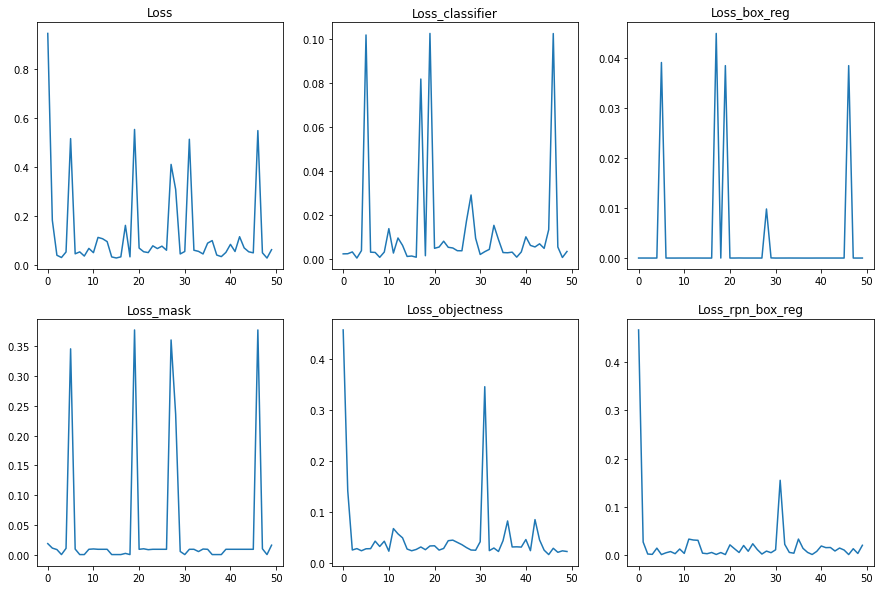

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].plot(range(len(logs)),losses)
ax[0,0].set_title('Loss')
ax[0,1].plot(range(len(logs)),losses_class)
ax[0,1].set_title('Loss_classifier')
ax[0,2].plot(range(len(logs)),losses_box_reg)
ax[0,2].set_title('Loss_box_reg')
ax[1,0].plot(range(len(logs)),losses_mask)
ax[1,0].set_title('Loss_mask')
ax[1,1].plot(range(len(logs)),losses_objectness)
ax[1,1].set_title('Loss_objectness')
ax[1,2].plot(range(len(logs)),losses_rpn_box_reg)
ax[1,2].set_title('Loss_rpn_box_reg')

In [52]:
torch.max(predictions[2]['masks'])

tensor(0.0048, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [33]:
model = model.cpu()

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (lesion) + background
num_classes = 3  # 2 classes (lesion benign + lesion malignant) + background


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
predictions

[{'boxes': tensor([[2.5803e+02, 2.3219e+02, 3.9800e+02, 2.9883e+02],
          [1.1064e+02, 1.4831e+02, 1.4184e+02, 1.6377e+02],
          [1.0749e+02, 1.3834e+02, 1.3233e+02, 1.7288e+02],
          [1.5622e+02, 1.9665e+02, 1.8711e+02, 2.1219e+02],
          [1.6788e+02, 1.8433e+02, 1.9201e+02, 2.2053e+02],
          [1.1911e+02, 1.3744e+02, 1.4418e+02, 1.7179e+02],
          [1.7898e+02, 1.8363e+02, 2.0447e+02, 2.1935e+02],
          [1.6970e+02, 1.9679e+02, 2.0021e+02, 2.1216e+02],
          [1.6757e+02, 1.7333e+02, 1.9111e+02, 2.0816e+02],
          [1.5799e+02, 1.8500e+02, 1.8792e+02, 2.0049e+02],
          [1.3170e+02, 1.3631e+02, 1.5699e+02, 1.7156e+02],
          [1.7809e+02, 2.9156e+02, 2.2092e+02, 3.0000e+02],
          [1.3280e+02, 1.4856e+02, 1.6463e+02, 1.6433e+02],
          [1.5361e+02, 2.9105e+02, 1.9505e+02, 3.0000e+02],
          [1.9327e+02, 1.7342e+02, 2.2308e+02, 1.8913e+02],
          [1.8191e+02, 1.9727e+02, 2.1213e+02, 2.1275e+02],
          [1.9056e+02, 1.0140e+

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
import utils as vision_utils

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
output = model(image_list, target_list)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x)           # Returns predictions

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
output

{'loss_classifier': tensor(0.0169, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0004, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(11.8512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(35.1903, grad_fn=<DivBackward0>)}